In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class datagen():
    def __init__(self, data):
        self.data = data
        self.n_classes = 13
        
        self.size = self.data.shape[0]
        self.pointer = 0 # initial pointer
        self.batchsize = 512
        self.epoch = 0
    def get_batch(self):
        if self.pointer + self.batchsize > self.size:
            batchsize = self.size - self.pointer
            start = self.pointer
            end = self.size - 1
            self.pointer = 0
            self.epoch += 1
            self.shuffle()
        else:
            batchsize = self.batchsize
            start = self.pointer
            end = self.pointer + batchsize
            self.pointer += batchsize
            
        X = self.data[start:end, :-1]
        y = np.array(self.data[start:end, -1])
        Y = np.zeros((y.shape[0], self.n_classes))
        Y[np.arange(y.size),y.astype(int)] = 1
        Y = Y.astype(int)
        return X, Y, y
    def get_epoch(self):
        return self.epoch
    def reset(self):
        self.epoch = 0
    def shuffle(self):
        np.random.shuffle(self.data)

In [3]:
class classifer():
    def __init__(self):
        self.lr = 5 * 1e-4
        self.n_classes = 13
        
        self.make_placeholders()
        self.make_nn()
        self.make_loss()
        self.make_train_op()
        
        self.sess = tf.Session()
        self.sess.run(tf.initializers.global_variables())
        
        self.saver = tf.train.Saver()
        
    def save(self):
        self.saver.save(self.sess, 'nn-classifier-v2')
        
    def load(self, name):
        self.saver.restore(self.sess, name)
        
    def make_placeholders(self):
        self.input = tf.placeholder(tf.float32, shape=[None, 4096], name='X')
        self.label = tf.placeholder(tf.int32, shape=[None, self.n_classes], name='label')
        
    def make_nn(self):
        X = tf.layers.dense(self.input, 512, activation=tf.nn.relu,
                              kernel_initializer=tf.keras.initializers.glorot_normal(), name='Dense_1')
        X = tf.layers.dense(X, 512, activation=tf.nn.relu,
                              kernel_initializer=tf.keras.initializers.glorot_normal(), name='Dense_2')
        X = tf.layers.dense(X, 512, activation=tf.nn.relu,
                              kernel_initializer=tf.keras.initializers.glorot_normal(), name='Dense_3')
        X = tf.layers.dense(X, 512, activation=tf.nn.relu,
                              kernel_initializer=tf.keras.initializers.glorot_normal(), name='Dense_4')
        self.logit = tf.layers.dense(X, self.n_classes, activation=None,
                              kernel_initializer=tf.keras.initializers.glorot_normal(), name='logits')
        
        self.prediction = tf.nn.softmax(self.logit)
        
    def make_loss(self):
        self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(self.label, self.logit))
    
    def make_train_op(self):
        self.optimizer = tf.train.AdamOptimizer(self.lr)
        self.train_op = self.optimizer.minimize(self.loss)
    
    def train(self, X, Y):
        loss, _ = self.sess.run([self.loss, self.train_op], feed_dict={self.input:X, self.label:Y})
        return loss
    
    def predict(self, X):
        prediction = self.sess.run([self.prediction], feed_dict={self.input:X})
        return prediction

In [251]:
all_data = np.load('data/np_array/all.npy')
idx = int(all_data.shape[0] * 0.9)
train = datagen(all_data[:idx, :])
test = datagen(all_data[idx:, :])

In [4]:
tf.reset_default_graph()
NN = classifer()

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


Itereation: 1000, Accuracy: 0.733931
Itereation: 2000, Accuracy: 0.741806
Itereation: 3000, Accuracy: 0.750073
Itereation: 4000, Accuracy: 0.756005
Itereation: 5000, Accuracy: 0.758889
Itereation: 6000, Accuracy: 0.762083
Itereation: 7000, Accuracy: 0.7635
Itereation: 8000, Accuracy: 0.764294
Itereation: 9000, Accuracy: 0.764578
Itereation: 10000, Accuracy: 0.765386
Itereation: 12000, Accuracy: 0.765972
Itereation: 13000, Accuracy: 0.766449
Itereation: 14000, Accuracy: 0.766029
Itereation: 15000, Accuracy: 0.766571
Itereation: 16000, Accuracy: 0.766982
Itereation: 17000, Accuracy: 0.767112


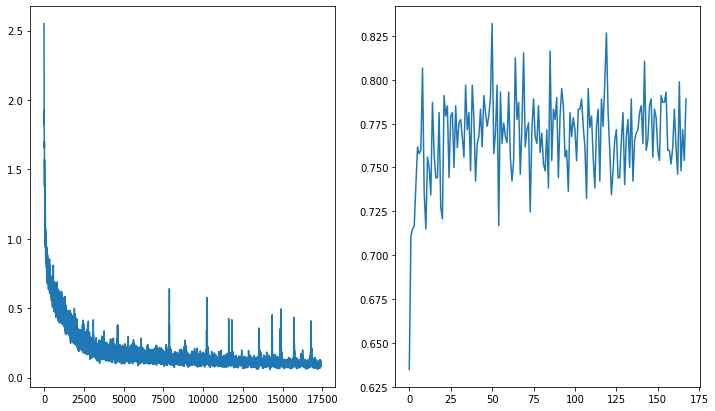

In [253]:
total_loss = []
total_accuracy = []
test.reset(); train.reset()
it = 0
while train.get_epoch() < 200:
    it += 1
    X, Y, _ = train.get_batch()
    if X.shape[0] < 256:
        continue
    loss = NN.train(X, Y)
    total_loss.append(loss)
    if it%100 == 0:
        X, Y, y = test.get_batch()
        predict = NN.predict(X)
        accuracy = np.sum(y == np.argmax(predict, axis=-1))/Y.shape[0]
        total_accuracy.append(accuracy)
        if  it %1000 == 0:
            print("Itereation: %d, Accuracy: %g"%(it, np.mean(total_accuracy)))
plt.figure(figsize=(12, 7))
plt.subplot(1,2,1)
plt.plot(total_loss)
plt.subplot(1,2,2)
plt.plot(total_accuracy)

In [6]:
#NN.save()
NN.load('nn-classifier-v2')

INFO:tensorflow:Restoring parameters from nn-classifier-v2


In [7]:
# import stuff
%load_ext autoreload
%autoreload 2

from random import randint

import numpy as np
import torch

In [8]:
# Load model
from InferSent.models import InferSent
model_version = 1
MODEL_PATH = "InferSent/encoder/infersent%s.pkl" % model_version
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': model_version}
model = InferSent(params_model)
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [9]:
# Keep it on CPU or put it on GPU
use_cuda = False
model = model.cuda() if use_cuda else model

# If infersent1 -> use GloVe embeddings. If infersent2 -> use InferSent embeddings.
W2V_PATH = 'InferSent/GloVe/glove.840B.300d.txt' if model_version == 1 else 'InferSent/fastText/crawl-300d-2M.vec'
model.set_w2v_path(W2V_PATH)

# Load embeddings of K most frequent words
model.build_vocab_k_words(K=100000)

Vocab size : 100000


In [258]:
def embedSentence(text):
    embeddings = model.encode([text], bsize=128, tokenize=True, verbose=True)
    return embeddings

In [42]:
Samples = ['Joe Biden will run for president and he is gonna lose so badly',
          'Scientist said we have no time to react, it is getting warmer, and weather is going to change the world',
          'Last night, someone got shot in Walmart, Beto has raised the issue to congress',
          'I think I have a nice skin, and you know what, France is going to invest on that, better cosmetics',
          'Attacking ISIS has been ordered by Donal Trump and US military',
          'Gas price went up as a result of stock rise',
          'I am sick as Fuck, insurance prices are high',
          'Big pharma is taking away peoples money, we need Bernie',
          'So you think France has a bad economy, Trump is going to send financial aid',
          '16 poeple reported dead on california fire that burned the forests',
          'Steve Ballmare bought LA Lakers in NBA']

Sample_embed = model.encode(Samples, bsize=128, tokenize=True, verbose=True)

Ticks = np.array(['Other', 'Politics', 'Media', 'Fashion', 'Foreign Policy', 'Immigration', 
         'Economy', 'Health', 'Art', 'Gender', 'Sport', 'Violence', 'Climate'])

Nb words kept : 188/190 (98.9%)
Speed : 8.7 sentences/s (cpu mode, bsize=128)


In [43]:
probs = NN.predict(Sample_embed)[0]
for i in range(probs.shape[0]):
    print(Ticks[np.flip(np.argsort(probs[i, :])[-2:])], np.flip(np.sort(probs[i, :])[-2:]) * 100)

['Politics' 'Other'] [99.543396   0.4348476]
['Climate' 'Other'] [9.9957794e+01 3.3542786e-02]
['Violence' 'Immigration'] [78.71664  12.532372]
['Other' 'Fashion'] [9.9999153e+01 8.4058684e-04]
['Politics' 'Other'] [1.0000000e+02 8.2047995e-09]
['Economy' 'Health'] [99.779945    0.12434642]
['Health' 'Politics'] [9.9999443e+01 5.6079804e-04]
['Politics' 'Other'] [9.983525e+01 7.411286e-02]
['Economy' 'Politics'] [98.85014    1.1111943]
['Climate' 'Other'] [95.08835   4.910608]
['Sport' 'Other'] [9.9910576e+01 8.9413956e-02]
['Other' 'Art'] [80.84186  18.801943]
